# <center>Real NVP [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_moons import *
from utils.training_mnist import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**Affine coupling layer:** Let $d=\frac{D}{2}$ (we could use an other d),
\begin{equation*}
    \begin{cases}
        z_{1:d} = x_{1:d} \\
        z_{d+1:D} = \exp(s(x_{1:d}))\odot x_{d+1:D}+m(x_{1:d})
    \end{cases}
\end{equation*}

with $m$ a neural network.

For inverting, we got:
\begin{equation*}
    \begin{cases}
        x_{1:d} = z_{1:d} \\
        x_{d+1:D} = \exp(-s(z_{1:d}))\odot (z_{d+1:D}-m(z_{1:d}))
    \end{cases}
\end{equation*}

And $\det J_T(x) = \exp{\sum_j s(x_{1:d})_j}$.

**Batch Norm Layer**: Let $m$ be the mean and $v$ be the variance (of a batch in training time, and of the whole training set in testing time), then a batch norm is:
\begin{equation*}
    x = (z-\beta)\odot e^{-\gamma}\odot (v+\epsilon)^{\frac12}+m
\end{equation*}
with $\gamma$ and $\beta$ some learnable parameters and $\epsilon$ a constant ensuring numerical stability. The invert is:
\begin{equation*}
    z = (x-m)\odot (v+\epsilon)^{-\frac12}\odot e^\gamma +\beta
\end{equation*}
Note that we could put $\gamma$ instead of $e^\gamma$. Then, we have: $\det J_T(x) = e^{\sum_j \gamma_j-\frac12\log(v_j+\epsilon)}$.

A Real NVP is composed of affine coupling layers and batch norm layers. To permute indices, we can just permute even and odd indices (or first and last part of vectors) as it is done here. We could also add permutation or reverse layers.

Possible improvement: Masked convolution: Partitioning is done by using a binary mask $b$:
\begin{equation*}
    y = b\odot x+(1-b)\odot(x\odot\exp(s(b\odot x))+t(b\odot x))
\end{equation*}

## Moons

In [ ]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126730


0 2.3270010948181152


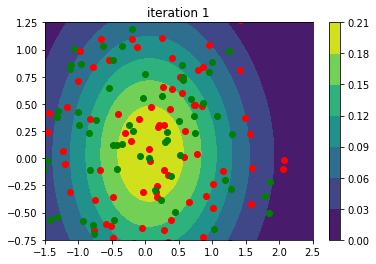

1000 1.2777148485183716


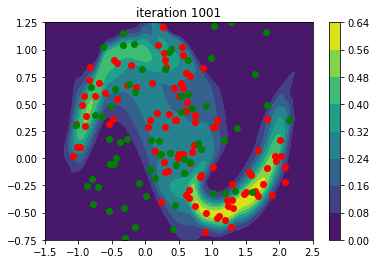

2000 1.2389333248138428


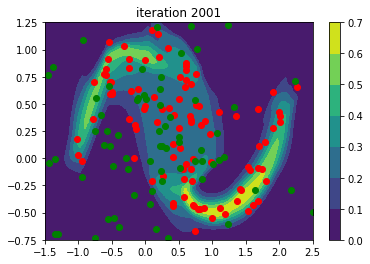

3000 1.2318181991577148


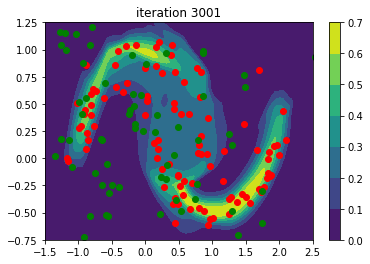

4000 1.160287618637085


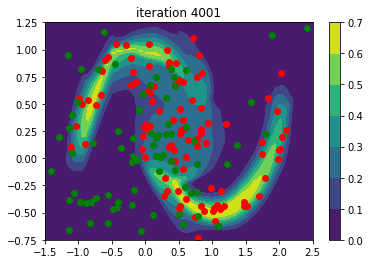

5000 1.2246259450912476


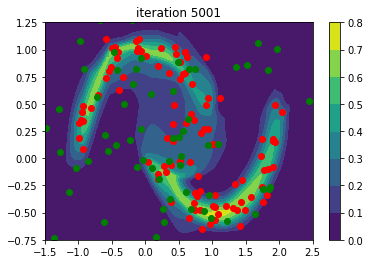

6000 1.0757626295089722


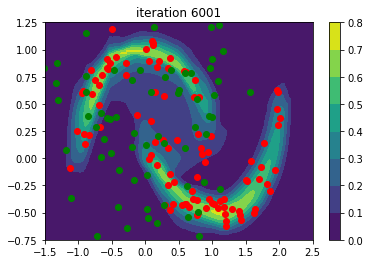

7000 1.1276748180389404


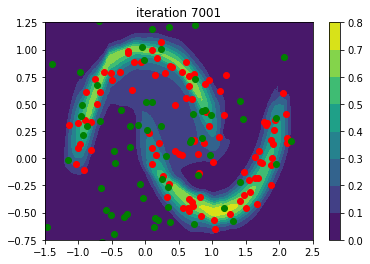

8000 1.1559257507324219


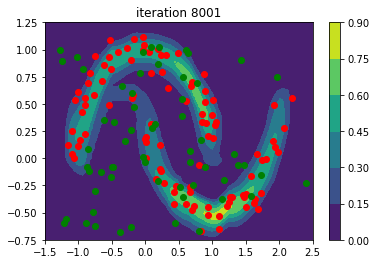

9000 1.106156349182129


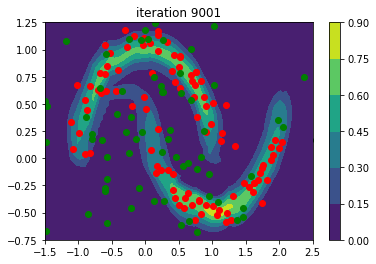

10000 1.0069233179092407


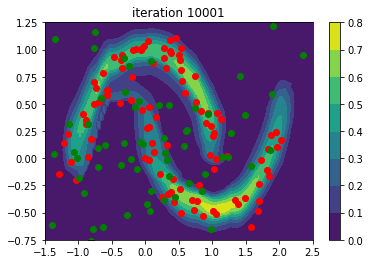

In [ ]:
train_loss = train_moons(model,optimizer,base_distr="normal")

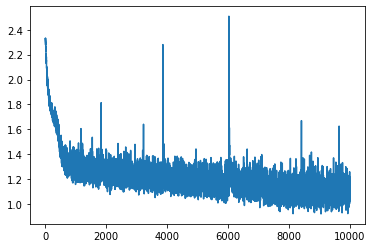

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126750


0 7.377962112426758


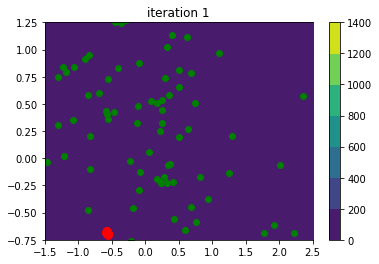

1000 5.40742826461792


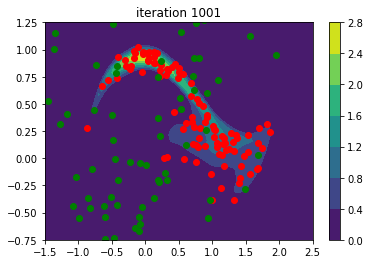

2000 4.423325538635254


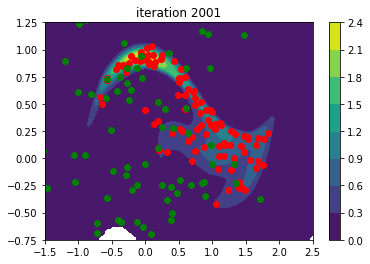

3000 3.769948720932007


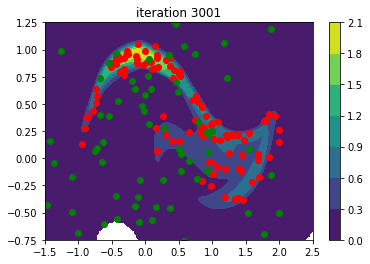

4000 2.9353623390197754


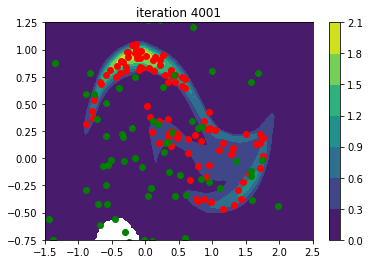

5000 2.595085859298706


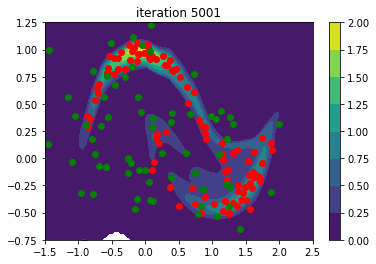

6000 2.097710609436035


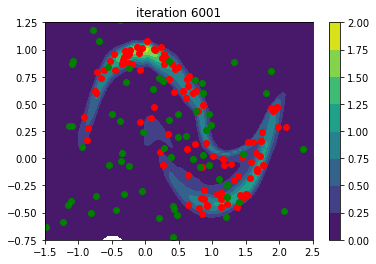

7000 1.685617446899414


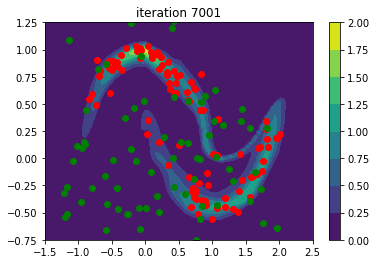

8000 1.5275635719299316


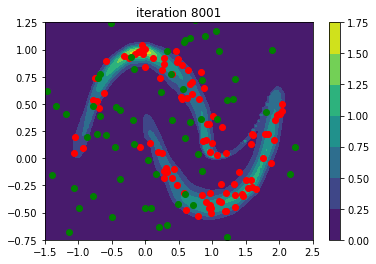

9000 1.4913158416748047


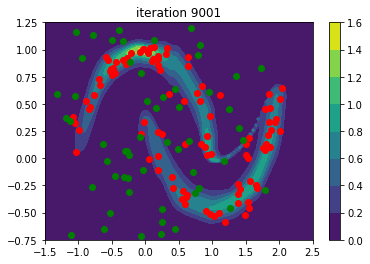

10000 1.1536610126495361


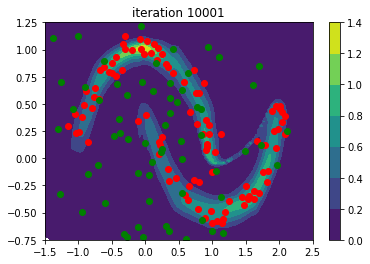

In [ ]:
train_loss = train_moons(model,optimizer,base_distr="normal")

## MNIST

In [5]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

def inverse_logit(img,lambd=1e-6):
    return (torch.sigmoid(img)-lambd)/(1-2*lambd)

In [4]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

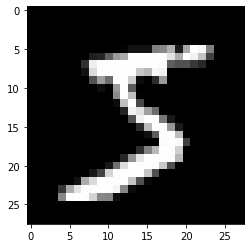

In [5]:
plt.imshow(inverse_logit(train_dataset[0][0]).reshape(28,28),"gray")
plt.show()

In [6]:
d = 784

## Add batch normalization?
shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))
    
model = NormalizingFlows(flows).to(device)

In [7]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  18546160


0 3450.308713477812


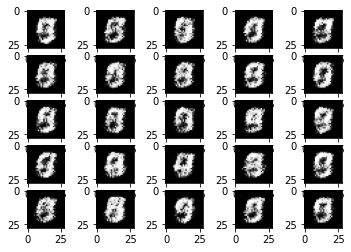

50 1195.2849430824394


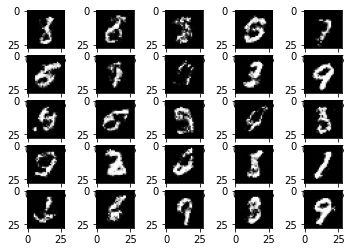

100 1165.939384411647


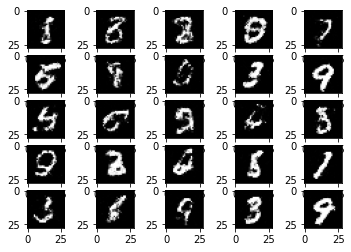

In [8]:
train_losses = train_mnist(model, optimizer, train_loader)

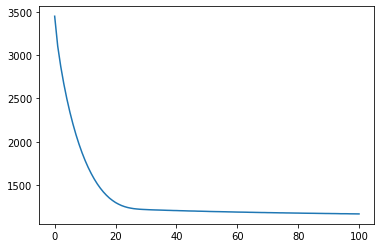

In [10]:
plt.plot(train_losses)
plt.show()

In [12]:
test_batch = []

base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(d,device=device),torch.eye(d,device=device))

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det, base_distr)

    test_batch.append(l.mean().item())

In [17]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = -log_likelihood / (784 * np.log(2.))
print(bpd)

2.2156580437604276


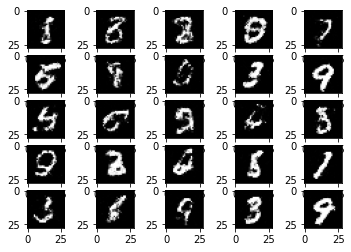

In [11]:
val_mnist(model, device)

## References

<a id="reference1"></a>

[1] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)